In [1]:
import pandas as pd
import csv
import string
from string import digits
import numpy as np

In [2]:
import nltk

## Bolt Topic Modeling

In [3]:
df=pd.read_csv("Bolt.csv",sep=",")
df.head()

,comment,comment_id,post_id,post_time,post_title,time
0,"Preconditioning, charge stats, mileage, etc ar...",epkew7k,bv20re,1.559270e+09,Is remote start/precondition using MyChevrolet...,2019-05-31 03:28:41
1,I don’t have any onstar services and precondit...,epk9lrk,bv20re,1.559270e+09,Is remote start/precondition using MyChevrolet...,2019-05-31 02:43:29
2,A cheat or handy way is to use Alexa. Since th...,epke6ad,bv20re,1.559270e+09,Is remote start/precondition using MyChevrolet...,2019-05-31 03:23:03
3,The original Bolts had 5 years of basic onstar...,epkv369,bv20re,1.559270e+09,Is remote start/precondition using MyChevrolet...,2019-05-31 05:47:38
4,Mine works only when in Bluetooth range after ...,epk8zjl,bv20re,1.559270e+09,Is remote start/precondition using MyChevrolet...,2019-05-31 02:37:28


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
data = df.comment.values.tolist()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['preconditioning', 'charge', 'stats', 'mileage', 'etc', 'are', 'all', 'free', 'for', 'years', 'no', 'onstar', 'subscription', 'required', 'or', 'you', 'can', 'use', 'the', 'fob', 'to', 'precondition', 'or', 'you', 'can', 'use', 'keypass', 'bluetooth', 'from', 'phone']]


In [7]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [8]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['precondition charge stat mileage free year subscription require use fob precondition use phone', 'onstar service precondition app work lock unlock door beep horn flash light dependent as long cell service work']


In [9]:
data_lemmatized

['precondition charge stat mileage free year subscription require use fob precondition use phone',
 'onstar service precondition app work lock unlock door beep horn flash light dependent as long cell service work',
 'cheat handy way use alexa basic connection continue year tell when cancel just enable chevrolet skill alexa use command alexa ask chevrolet unlock car course alexa start car alexa respond ask pin when watch mine usually take second car quite reliable just fyi',
 'original bolt year basic onstar include other say discontinue now basic no longer include so trial end range pay',
 'work only when range cancel',
 'still work expire understanding get limited service free year include monitoring monthly email report don know require precondition probably so then limited service plan',
 'buy tell year promotion end prior purchase free trial end indeed stop work prepay full year get discount think basic plan allow remote start car wind month irritate pay worth work area foot car so

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['preconditioning', 'charge', 'stats', 'mileage', 'etc', 'are', 'all', 'free', 'for', 'years', 'no', 'onstar', 'subscription', 'required', 'or', 'you', 'can', 'use', 'the', 'fob', 'to', 'precondition', 'or', 'you', 'can', 'use', 'keypass', 'bluetooth', 'from', 'phone']


In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/mow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend([
                   'great',
                   'good',
                   'from', 
                   'subject',
                   're', 
                   'edu', 'lol',
                   'use','take','love','thing','wrong','never','car',
                   'think','go','feel',
                   'well','also','really','nice','bad','damn','amazing','awesome'])

In [14]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Remove Stop Words
data_lemmatized= remove_stopwords(data_lemmatized)


print(data_lemmatized[:1])

[['precondition', 'charge', 'stat', 'mileage', 'free', 'year', 'subscription', 'require', 'fob', 'precondition', 'phone']]


In [15]:
data_lemmatized

[['precondition',
  'charge',
  'stat',
  'mileage',
  'free',
  'year',
  'subscription',
  'require',
  'fob',
  'precondition',
  'phone'],
 ['onstar',
  'service',
  'precondition',
  'app',
  'work',
  'lock',
  'unlock',
  'door',
  'beep',
  'horn',
  'flash',
  'light',
  'dependent',
  'long',
  'cell',
  'service',
  'work'],
 ['cheat',
  'handy',
  'way',
  'alexa',
  'basic',
  'connection',
  'continue',
  'year',
  'tell',
  'cancel',
  'enable',
  'chevrolet',
  'skill',
  'alexa',
  'command',
  'alexa',
  'ask',
  'chevrolet',
  'unlock',
  'course',
  'alexa',
  'start',
  'alexa',
  'respond',
  'ask',
  'pin',
  'watch',
  'mine',
  'usually',
  'second',
  'quite',
  'reliable',
  'fyi'],
 ['original',
  'bolt',
  'year',
  'basic',
  'onstar',
  'include',
  'say',
  'discontinue',
  'basic',
  'longer',
  'include',
  'trial',
  'end',
  'range',
  'pay'],
 ['work', 'range', 'cancel'],
 ['still',
  'work',
  'expire',
  'understanding',
  'get',
  'limited',
  's

## Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('charge', 1),
  ('fob', 1),
  ('free', 1),
  ('mileage', 1),
  ('phone', 1),
  ('precondition', 2),
  ('require', 1),
  ('stat', 1),
  ('subscription', 1),
  ('year', 1)],
 [('precondition', 1),
  ('app', 1),
  ('beep', 1),
  ('cell', 1),
  ('dependent', 1),
  ('door', 1),
  ('flash', 1),
  ('horn', 1),
  ('light', 1),
  ('lock', 1),
  ('long', 1),
  ('onstar', 1),
  ('service', 2),
  ('unlock', 1),
  ('work', 2)]]

## Building the Topic Model

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.096*"front" + 0.091*"easy" + 0.088*"least" + 0.054*"lose" + 0.042*"stick" '
  '+ 0.040*"garage" + 0.039*"design" + 0.033*"soon" + 0.031*"imagine" + '
  '0.028*"cut"'),
 (1,
  '0.113*"say" + 0.100*"want" + 0.092*"back" + 0.090*"try" + 0.061*"put" + '
  '0.046*"maybe" + 0.045*"turn" + 0.036*"dealership" + 0.034*"seat" + '
  '0.031*"week"'),
 (2,
  '0.125*"tire" + 0.120*"winter" + 0.098*"low" + 0.095*"bit" + 0.068*"driver" '
  '+ 0.057*"road" + 0.050*"summer" + 0.029*"driving" + 0.025*"safe" + '
  '0.022*"reduce"'),
 (3,
  '0.099*"make" + 0.081*"need" + 0.059*"find" + 0.054*"actually" + 0.045*"lot" '
  '+ 0.037*"home" + 0.036*"plan" + 0.034*"set" + 0.034*"pay" + 0.034*"give"'),
 (4,
  '0.275*"know" + 0.108*"minute" + 0.103*"leave" + 0.095*"right" + 0.082*"let" '
  '+ 0.038*"mention" + 0.022*"weekend" + 0.018*"glad" + 0.016*"strand" + '
  '0.002*"nowhere"'),
 (5,
  '0.186*"much" + 0.123*"keep" + 0.109*"big" + 0.064*"wait" + 0.060*"slow" + '
  '0.038*"small" + 0.034*"second" + 0.0

## Compute Model Perplexity and Coherence Score

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -16.812437988555605

Coherence Score:  0.3556728065039189


## Visualize the topics-keywords

In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.save_html(vis, 'lda_20_Bolt.html')

/usr/local/var/pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Building LDA Mallet Model

In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/mow/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)


In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(4,
  [('back', 0.06074279763970843),
   ('put', 0.03471017007983339),
   ('happen', 0.033321763276640055),
   ('door', 0.032974661575841724),
   ('leave', 0.030544949670253386),
   ('start', 0.025338424158278375),
   ('pull', 0.025338424158278375),
   ('open', 0.023602915654286707),
   ('remove', 0.021520305449496704),
   ('handle', 0.017355085039916694)]),
 (16,
  [('phone', 0.05919395465994962),
   ('work', 0.042821158690176324),
   ('app', 0.036523929471032744),
   ('plan', 0.034634760705289674),
   ('issue', 0.031486146095717885),
   ('update', 0.030541561712846346),
   ('datum', 0.02172544080604534),
   ('show', 0.020151133501259445),
   ('add', 0.019836272040302267),
   ('connect', 0.018261964735516372)]),
 (5,
  [('charge', 0.2088235294117647),
   ('charger', 0.10427807486631016),
   ('plug', 0.045989304812834225),
   ('hour', 0.04090909090909091),
   ('level', 0.03823529411764706),
   ('fast', 0.029679144385026737),
   ('charging', 0.016310160427807488),
   ('amp', 0.01631016

## the optimal number of topics for LDA

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

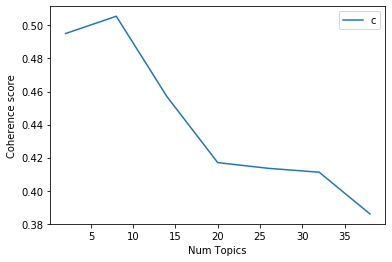

In [26]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4951
Num Topics = 8  has Coherence Value of 0.5055
Num Topics = 14  has Coherence Value of 0.4569
Num Topics = 20  has Coherence Value of 0.417
Num Topics = 26  has Coherence Value of 0.4135
Num Topics = 32  has Coherence Value of 0.4112
Num Topics = 38  has Coherence Value of 0.3859


In [28]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.052*"year" + 0.047*"make" + 0.042*"model" + 0.040*"tesla" + 0.035*"lot" + '
  '0.028*"people" + 0.025*"vehicle" + 0.016*"pretty" + 0.015*"low" + '
  '0.015*"check"'),
 (1,
  '0.026*"stop" + 0.022*"turn" + 0.019*"change" + 0.018*"brake" + '
  '0.018*"sound" + 0.014*"driver" + 0.013*"door" + 0.012*"hear" + '
  '0.012*"button" + 0.012*"light"'),
 (2,
  '0.108*"charge" + 0.049*"charger" + 0.036*"time" + 0.022*"plug" + '
  '0.020*"home" + 0.019*"fast" + 0.018*"leave" + 0.018*"level" + '
  '0.016*"option" + 0.014*"station"'),
 (3,
  '0.058*"work" + 0.028*"issue" + 0.025*"phone" + 0.020*"part" + 0.016*"find" '
  '+ 0.015*"app" + 0.014*"show" + 0.013*"give" + 0.013*"service" + '
  '0.013*"update"'),
 (4,
  '0.059*"battery" + 0.058*"mile" + 0.041*"range" + 0.035*"trip" + 0.032*"day" '
  '+ 0.030*"long" + 0.025*"time" + 0.022*"hour" + 0.017*"minute" + '
  '0.015*"heat"'),
 (5,
  '0.056*"bolt" + 0.032*"tire" + 0.032*"back" + 0.028*"volt" + 0.023*"seat" + '
  '0.020*"point" + 0.020*"whee

## Finding the dominant topic in each sentence

In [29]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1444,"work, issue, phone, part, find, app, show, giv...","Preconditioning, charge stats, mileage, etc ar..."
1,1,3.0,0.2260,"work, issue, phone, part, find, app, show, giv...",I don’t have any onstar services and precondit...
2,2,3.0,0.2893,"work, issue, phone, part, find, app, show, giv...",A cheat or handy way is to use Alexa. Since th...
3,3,3.0,0.1602,"work, issue, phone, part, find, app, show, giv...",The original Bolts had 5 years of basic onstar...
4,4,3.0,0.1557,"work, issue, phone, part, find, app, show, giv...",Mine works only when in Bluetooth range after ...
5,5,3.0,0.1828,"work, issue, phone, part, find, app, show, giv...",Mine still works after OnStar expired. My unde...
6,6,3.0,0.1851,"work, issue, phone, part, find, app, show, giv...",Bought mine in June if 2018. I was told that t...
7,7,4.0,0.1422,"battery, mile, range, trip, day, long, time, h...",You can also use the key fob to precondition y...
8,8,1.0,0.1378,"stop, turn, change, brake, sound, driver, door...",[removed]
9,9,1.0,0.1400,"stop, turn, change, brake, sound, driver, door...",[removed]


## Find the most representative document for each topic

In [30]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4639,"year, make, model, tesla, lot, people, vehicle...",You are mentally unstable. The guy has made m...
1,1.0,0.4836,"stop, turn, change, brake, sound, driver, door...",I have experienced this many time and is as yo...
2,2.0,0.5701,"charge, charger, time, plug, home, fast, leave...",Are you planning to use the current plug that'...
3,3.0,0.4733,"work, issue, phone, part, find, app, show, giv...",There's nothing wrong with giving them your cr...
4,4.0,0.5213,"battery, mile, range, trip, day, long, time, h...",I have noticed the Thermal Battery Management ...


## Topic distribution across documents

In [31]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:20]

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,3.0,"work, issue, phone, part, find, app, show, giv...",767.0,0.1807
1.0,3.0,"work, issue, phone, part, find, app, show, giv...",536.0,0.1263
2.0,3.0,"work, issue, phone, part, find, app, show, giv...",475.0,0.1119
3.0,3.0,"work, issue, phone, part, find, app, show, giv...",560.0,0.1319
4.0,3.0,"work, issue, phone, part, find, app, show, giv...",474.0,0.1117
5.0,3.0,"work, issue, phone, part, find, app, show, giv...",469.0,0.1105
6.0,3.0,"work, issue, phone, part, find, app, show, giv...",390.0,0.0919
7.0,4.0,"battery, mile, range, trip, day, long, time, h...",574.0,0.1352
8.0,1.0,"stop, turn, change, brake, sound, driver, door...",NaN,NaN
9.0,1.0,"stop, turn, change, brake, sound, driver, door...",NaN,NaN
